In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
data = pd.read_pickle('../data/full_data.pkl')
data.head()

,Adj Close,Volume,pct_change_adj_close,lag_pct_change_adj_close,lag_pct_change_volume,lag_ma5_pct_change_adj_close,topic 1,consumption,foreign_exchange_rate,inflation_x,financial_market,topic 6,sentiment_mc,sentiment_zstc,ffr,unemployment_rate,median_cpi,retail_sales,10_year_treasury_yeild,10year_3month_yield_spread,vix,us_china_exchange_rate,us_japan_exchange_rate,sahm,inflation_y,growth,Three_Component_Index,News_Based_Policy_Uncert_Index,price_increase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-04-01,450.299988,234530000,-0.303324,-0.066373,20.762144,0.161433,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,3.31,7.1,4.09652,176749.0,5.97,3.10,13.02,5.7333,114.1,-0.03,0.348918,0.582113,109.256836,89.651123,0
1993-04-02,441.390015,323330000,-1.978675,-0.303324,-15.996275,-0.024659,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,3.13,7.1,4.09652,176749.0,5.97,3.19,14.50,5.7333,114.2,-0.03,0.348918,0.582113,109.256836,89.651123,0
1993-04-05,442.290009,296080000,0.203900,-1.978675,37.862960,-0.282885,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,3.15,7.1,4.09652,176749.0,5.97,3.16,14.12,5.7333,113.6,-0.03,0.348918,0.582113,109.256836,89.651123,1
1993-04-06,441.160004,293680000,-0.255490,0.203900,-8.427922,-0.375652,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,2.97,7.1,4.09652,176749.0,5.97,3.10,14.24,5.7333,114.0,-0.03,0.348918,0.582113,109.256836,89.651123,0
1993-04-07,442.730011,300000000,0.355882,-0.255490,-0.810592,-0.479992,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,2.93,7.1,4.09652,176749.0,5.97,3.09,13.64,5.7333,113.7,-0.03,0.348918,0.582113,109.256836,89.651123,1


### RNN:


In [5]:
data.head()

,Adj Close,Volume,pct_change_adj_close,lag_pct_change_adj_close,lag_pct_change_volume,lag_ma5_pct_change_adj_close,topic 1,consumption,foreign_exchange_rate,inflation_x,financial_market,topic 6,sentiment_mc,sentiment_zstc,ffr,unemployment_rate,median_cpi,retail_sales,10_year_treasury_yeild,10year_3month_yield_spread,vix,us_china_exchange_rate,us_japan_exchange_rate,sahm,inflation_y,growth,Three_Component_Index,News_Based_Policy_Uncert_Index,price_increase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-04-01,450.299988,234530000,-0.303324,-0.066373,20.762144,0.161433,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,3.31,7.1,4.09652,176749.0,5.97,3.10,13.02,5.7333,114.1,-0.03,0.348918,0.582113,109.256836,89.651123,0
1993-04-02,441.390015,323330000,-1.978675,-0.303324,-15.996275,-0.024659,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,3.13,7.1,4.09652,176749.0,5.97,3.19,14.50,5.7333,114.2,-0.03,0.348918,0.582113,109.256836,89.651123,0
1993-04-05,442.290009,296080000,0.203900,-1.978675,37.862960,-0.282885,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,3.15,7.1,4.09652,176749.0,5.97,3.16,14.12,5.7333,113.6,-0.03,0.348918,0.582113,109.256836,89.651123,1
1993-04-06,441.160004,293680000,-0.255490,0.203900,-8.427922,-0.375652,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,2.97,7.1,4.09652,176749.0,5.97,3.10,14.24,5.7333,114.0,-0.03,0.348918,0.582113,109.256836,89.651123,0
1993-04-07,442.730011,300000000,0.355882,-0.255490,-0.810592,-0.479992,0.052435,0.33777,0.102628,0.422744,0.049573,0.034851,1.11151,0.402003,2.93,7.1,4.09652,176749.0,5.97,3.09,13.64,5.7333,113.7,-0.03,0.348918,0.582113,109.256836,89.651123,1


In [140]:
train, test = train_test_split(
    data.drop(columns=['Adj Close', 'pct_change_adj_close', 'Volume']), 
    shuffle=False, 
    test_size=0.1
)

In [141]:
mm = MinMaxScaler()
training_set_scaled = mm.fit_transform(train)

In [142]:
len(training_set_scaled)

6870

In [ ]:
# https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn

In [116]:
def rnn_data_structure(data, timesteps = 10):
    X = []
    y = []
    
    for i in range(timesteps-1, len(data)):
        X.append(data[i-timesteps+1:i+1, :-1])
        y.append(data[i, -1])
    X, y = np.array(X), np.array(y)
    
    return X, y

In [117]:
X_train, y_train = rnn_data_structure(training_set_scaled)

In [118]:
test_set_scaled = mm.transform(test)
X_test, y_test = rnn_data_structure(test_set_scaled)

In [119]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6811, 60, 26)
(6811,)
(705, 60, 26)
(705,)


In [120]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(60, 26)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 128)           79360     
                                                                 
 lstm_4 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 163905 (640.25 KB)
Trainable params: 163

In [121]:
model.compile(loss='bce', optimizer='rmsprop', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [122]:
# Fit
history = model.fit(
    X_train,
    y_train,
    validation_data= (X_test, y_test),
    epochs=20,
    batch_size = 64,
    callbacks = es
)

Epoch 1/20
107/107 [==============================] - 11s 93ms/step - loss: 0.6940 - acc: 0.5299 - val_loss: 0.6929 - val_acc: 0.5121
Epoch 2/20
107/107 [==============================] - 10s 90ms/step - loss: 0.6914 - acc: 0.5355 - val_loss: 0.6988 - val_acc: 0.5121
Epoch 3/20
107/107 [==============================] - 10s 93ms/step - loss: 0.6908 - acc: 0.5381 - val_loss: 0.6955 - val_acc: 0.5121
Epoch 4/20
107/107 [==============================] - 9s 89ms/step - loss: 0.6905 - acc: 0.5380 - val_loss: 0.6973 - val_acc: 0.5121
Epoch 5/20
107/107 [==============================] - 10s 93ms/step - loss: 0.6911 - acc: 0.5388 - val_loss: 0.6951 - val_acc: 0.5121
Epoch 6/20
107/107 [==============================] - 38s 358ms/step - loss: 0.6903 - acc: 0.5415 - val_loss: 0.6941 - val_acc: 0.5121
Epoch 7/20
107/107 [==============================] - 14s 134ms/step - loss: 0.6903 - acc: 0.5375 - val_loss: 0.6966 - val_acc: 0.5121
Epoch 8/20
107/107 [==============================] - 14s 125

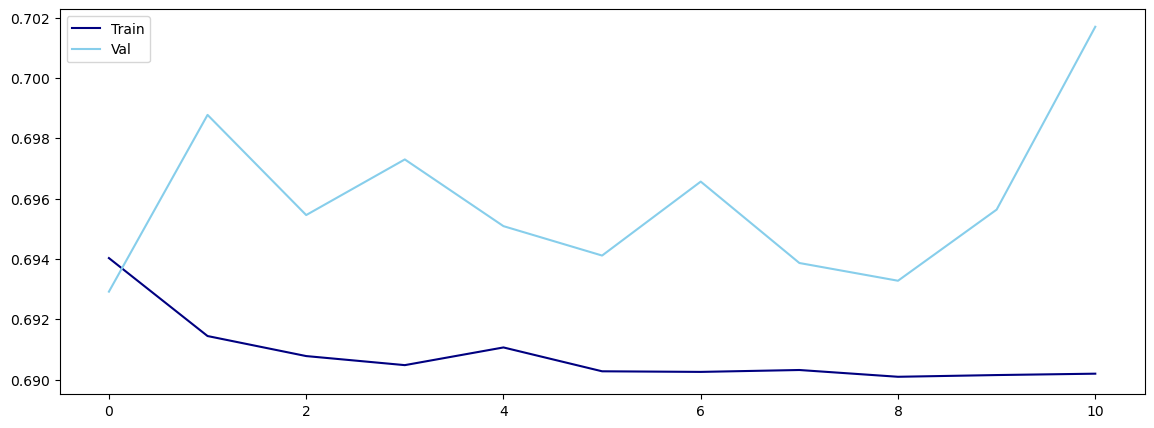

In [123]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], c='navy', label='Train')
plt.plot(history.history['val_loss'], c='skyblue', label='Val')
plt.legend();

In [124]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 40ms/step - loss: 0.6929 - acc: 0.5121


[0.6929138898849487, 0.5120567083358765]

In [125]:
pred_test = model.predict(X_test)

23/23 [==============================] - 1s 17ms/step


In [126]:
pred_test = pred_test.reshape(-1)
pred_test.shape

(705,)

In [127]:
print(pred_test.min())
print(pred_test.max())

0.51679987
0.5255402


In [139]:
threshold = 0.52
y_pred = np.where(pred_test >= threshold, 1, 0)

In [129]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[135 209]
 [128 233]]


              precision    recall  f1-score   support

         0.0       0.50      0.67      0.58       344
         1.0       0.54      0.37      0.44       361

    accuracy                           0.52       705
   macro avg       0.52      0.52      0.51       705
weighted avg       0.52      0.52      0.51       705



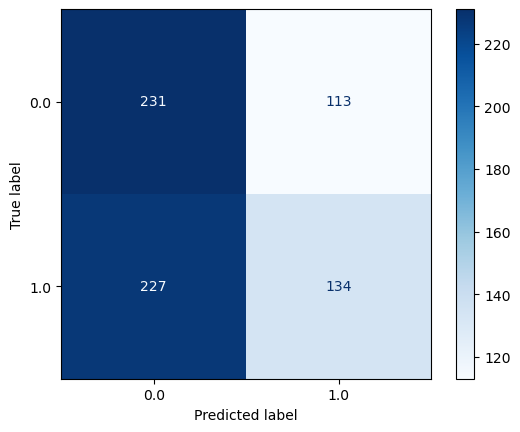

In [138]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues');

In [115]:
y_test.mean()

0.5205298013245033

### MAchine learning:

In [144]:
data.columns

Index(['Adj Close', 'Volume', 'pct_change_adj_close',
       'lag_pct_change_adj_close', 'lag_pct_change_volume',
       'lag_ma5_pct_change_adj_close', 'topic 1', 'consumption',
       'foreign_exchange_rate', 'inflation_x', 'financial_market', 'topic 6',
       'sentiment_mc', 'sentiment_zstc', 'ffr', 'unemployment_rate',
       'median_cpi', 'retail_sales', '10_year_treasury_yeild',
       '10year_3month_yield_spread', 'vix', 'us_china_exchange_rate',
       'us_japan_exchange_rate', 'sahm', 'inflation_y', 'growth',
       'Three_Component_Index', 'News_Based_Policy_Uncert_Index',
       'price_increase'],
      dtype='object')

In [147]:
X = data.drop(columns=['Adj Close', 'pct_change_adj_close', 'Volume', 'price_increase'])
y = data['price_increase']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape, X_test.shape)

(6870, 25) (764, 25)


In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier



In [153]:
from sklearn import metrics

In [156]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]
 
for i in range(3):
    models[i].fit(X_train, y_train)
    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(
    y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(
    y_test, models[i].predict_proba(X_test)[:,1]))
    print()

LogisticRegression() : 
Training Accuracy :  0.6060193501773528
Validation Accuracy :  0.6135681669928245

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.6942961766991445
Validation Accuracy :  0.5939403302777492

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accura

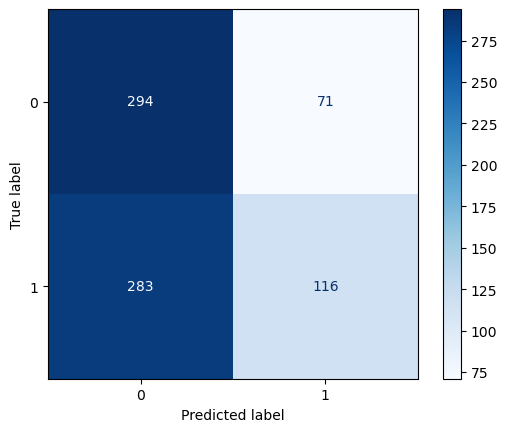

In [161]:
ConfusionMatrixDisplay.from_estimator(models[0], X_test, y_test, cmap='Blues')
plt.show()